In [1]:
root_dir = '../data/lrs2_v1/mvlrs_v1/'
annotation = 'pretrain.txt'

In [2]:
ls

 Volume in drive D is Work
 Volume Serial Number is 9C4A-7C15

 Directory of D:\LipNet\pipelines

28/06/2023  07:43 am    <DIR>          .
27/06/2023  11:42 pm    <DIR>          ..
27/06/2023  11:46 pm    <DIR>          .ipynb_checkpoints
20/09/2017  05:31 am                50 00001.txt
27/06/2023  10:41 pm           129,565 00001_lips.mp4
20/09/2017  05:16 am            12,305 00098.txt
27/06/2023  02:29 pm        19,999,174 00098_lips.mp4
28/06/2023  04:44 am           268,405 animation.gif
28/06/2023  12:19 am               130 bbaf2n.align
28/06/2023  07:40 am           405,430 dataset.gif
28/06/2023  04:53 am           405,430 input_frames.gif
28/06/2023  07:43 am         1,568,035 lrs2_dataset.ipynb
28/06/2023  05:13 am    <DIR>          multiprocessing
27/06/2023  10:21 am               619 multiprocessing.txt
              10 File(s)     22,789,143 bytes
               4 Dir(s)  332,687,568,896 bytes free


In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

## Load Video

In [4]:
def load_video(path):
    """Loads the frames of a video file, converts frames to grayscale,
    crops the mouth, and standardises the frames.
    
    Args:
        path (string): Path for the video file.
        
    Returns:
        List[float]: Frames of the video in a tensor.
    """
    cap = cv2.VideoCapture(path)
    frames = []

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        flag, frame = cap.read()

        if not flag:
            return

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame)


    cap.release()

    # Normalise
    frames = np.stack(frames)
    mean = np.mean(frames.astype(np.float32))
    std = np.std(frames.astype(np.float32))

    normalized_frames = (frames.astype(np.float32) - mean) / std
    
    return normalized_frames

In [5]:
path = '00001_lips.mp4'

In [6]:
x = load_video(path)

In [7]:
type(x)

numpy.ndarray

In [8]:
x.shape

(35, 96, 96)

## Load Tokens


In [9]:
# Create our vocab list
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
from sklearn.preprocessing import LabelEncoder

char_to_num = LabelEncoder()
char_to_num.fit(vocab)

LabelEncoder()

In [11]:
# Test the conversion
char_sequence = ['b', 'a', 'd', 'c', 'e']
numeric_sequence = char_to_num.transform(char_sequence)
numeric_sequence

array([14, 13, 16, 15, 17])

In [12]:
char_to_num.inverse_transform(numeric_sequence)

array(['b', 'a', 'd', 'c', 'e'], dtype='<U1')

## Loading alignments

In [13]:
line = "Text:  WHEN YOU'RE COOKING CHIPS AT HOME"
line = line.lower()

In [14]:
line.split()

['text:', 'when', "you're", 'cooking', 'chips', 'at', 'home']

In [15]:
def load_alignments(path): 
    """ Loads the alignments and tokenizes them.
    Args:
        path (str): Path to the alignment file.
        
    Returns:
        np.ndarray: Tokens in a tensor.
    """
    with open(path, 'r') as f: 
        line = f.readline() 
    
    line = line.lower()
        
    tokens = []
    words = line.split()

    for word in words:
        # Ignore start string 'text:'
        if word != 'text:': 
            tokens = [*tokens,' ', word]
    
    
    char_list = [char for string in tokens for char in string]
    
    return char_to_num.transform(char_list)[1:]

In [16]:
x = load_alignments('00001.txt')
char_to_num.inverse_transform(x)

array(['w', 'h', 'e', 'n', ' ', 'y', 'o', 'u', "'", 'r', 'e', ' ', 'c',
       'o', 'o', 'k', 'i', 'n', 'g', ' ', 'c', 'h', 'i', 'p', 's', ' ',
       'a', 't', ' ', 'h', 'o', 'm', 'e'], dtype='<U1')

## Loading Both

In [17]:
def get_dir_filename(path):
    """Returns a list of directories and the filename.
    Args:
        path (str): A path.
        
    Returns:
        np.ndarray: The directories.
        string: Filename.
    """
    path, file_name = os.path.split(path)
    directories = []

    while True:
        path, directory = os.path.split(path)
        if directory != "":
            directories.append(directory)
        else:
            if path != "":
                directories.append(path)
            break
            
    # Reverse the directories list
    directories = directories[::-1]
            
    return directories, file_name

In [18]:
dirs, file_name = get_dir_filename('./dir1/dir2/file')

In [19]:
os.path.join(*dirs, f'{file_name}.align')

'.\\dir1\\dir2\\file.align'

In [20]:
def load_data(path):
    """Returns the loaded frames and alignements using video path.
    Args:
        path (str): The path to the alignment file.
    Returns:
        np.ndarray: Frames of the video in a tensor.
        np.ndarray: Tokens in a tensor.
        """
    
    dirs, file_name = get_dir_filename(path)
    
    # Remove the extension
    file_name = file_name.split('.')[0]
    
    alignment_path = path
    video_path = os.path.join(*dirs, f'{file_name}_lips.mp4')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [21]:
frames, alignments = load_data('./00001.txt')

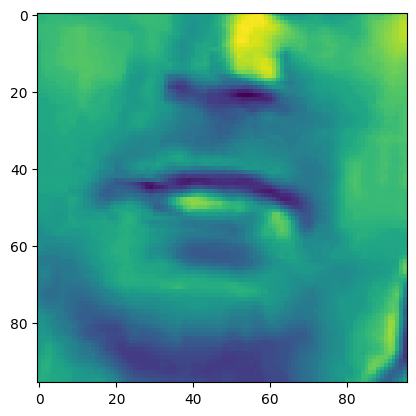

In [22]:
plt.imshow(frames[0])

In [23]:
import imageio

In [24]:
imageio.mimsave('./animation.gif', frames, fps=10)

Lossy conversion from float32 to uint8. Range [-2.6680407524108887, 2.7504992485046387]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.8738081455230713, 2.7504992485046387]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.6680407524108887, 2.647615671157837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.9081027507781982, 2.647615671157837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.8395135402679443, 2.510437488555908]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-3.148164749145508, 2.647615671157837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.9081027507781982, 3.67645239830

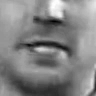

In [25]:
alignments

array([35, 20, 17, 26,  0, 37, 27, 33,  2, 30, 17,  0, 15, 27, 27, 23, 21,
       26, 19,  0, 15, 20, 21, 28, 31,  0, 13, 32,  0, 20, 27, 25, 17])

In [26]:
char_to_num.inverse_transform(alignments)

array(['w', 'h', 'e', 'n', ' ', 'y', 'o', 'u', "'", 'r', 'e', ' ', 'c',
       'o', 'o', 'k', 'i', 'n', 'g', ' ', 'c', 'h', 'i', 'p', 's', ' ',
       'a', 't', ' ', 'h', 'o', 'm', 'e'], dtype='<U1')

In [27]:
frames.shape

(35, 96, 96)

## Padding to the video

In [28]:
def add_padding_to_video(video_array, desired_frames=180):
    num_frames = video_array.shape[0]

    assert num_frames <= desired_frames
    
    padding_needed = desired_frames - num_frames

    # Extract the last frame to use for padding
    padding_frame = video_array[-1]

   # Create padding frames filled with zeros
    padding_frames = np.zeros((padding_needed,) + video_array.shape[1:], dtype=video_array.dtype)

    padded_video_array = np.concatenate((video_array, padding_frames), axis=0)

    return padded_video_array

In [29]:
x = add_padding_to_video(frames)

In [30]:
x.shape

(180, 96, 96)

In [31]:
imageio.mimsave('./input_frames.gif', x, fps=10)

Lossy conversion from float32 to uint8. Range [-2.6680407524108887, 2.7504992485046387]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.8738081455230713, 2.7504992485046387]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.6680407524108887, 2.647615671157837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.9081027507781982, 2.647615671157837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.8395135402679443, 2.510437488555908]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-3.148164749145508, 2.647615671157837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.9081027507781982, 3.67645239830

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

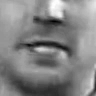

In [32]:
def add_padding_to_tokens(token_array, desired_length = 300, pad_value=0):
    current_length = token_array.shape[0]

    assert current_length <= desired_length

    padding_needed = desired_length - current_length

    # Pad the array with the specified value
    padded_array = np.pad(token_array, (0, padding_needed), mode='constant', constant_values=pad_value)

    return padded_array

In [33]:
add_padding_to_tokens(alignments)

array([35, 20, 17, 26,  0, 37, 27, 33,  2, 30, 17,  0, 15, 27, 27, 23, 21,
       26, 19,  0, 15, 20, 21, 28, 31,  0, 13, 32,  0, 20, 27, 25, 17,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [34]:
type(add_padding_to_tokens(alignments))

numpy.ndarray

## Dataset

In [35]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [76]:
class FelixLRS2Dataset(Dataset):
    """LRS2 dataset"""
    
    def __init__(self, alignment_file, root_dir, frames_length = 1000, tokens_length = 10000, transform=None):
        """
        Args:
            alignment_file (str): Path to the txt file for the current split.
            root_dir (str): Directory for the current split.
            frames_length (int): Total number of frames for padding purposes.
            tokens_length (int): Total number of tokens for padding purposes.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        with open(alignment_file, 'r') as f:
            lines = f.readlines()
            
        # Remove the letter ending in test.txt
        self.clips = [line.split()[0] for line in lines]
        
        self.root_dir = root_dir
        self.frames_length = frames_length
        self.tokens_length = tokens_length
        self.transform = transform
        
        # Create our vocab list
        vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
        self.char_to_num = LabelEncoder()
        self.char_to_num.fit(vocab)
        
    def __len__(self):
        return len(self.clips)
    
    def load_video(self, path):
        """Loads the frames of a video file, converts frames to grayscale,
        crops the mouth, and standardises the frames.

        Args:
            path (string): Path for the video file.

        Returns:
            List[float]: Frames of the video in a tensor.
        """
        cap = cv2.VideoCapture(path)
        frames = []

        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            flag, frame = cap.read()
            
            if not flag:
                return
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)

        cap.release()

        # Normalise
        frames = np.stack(frames)
        mean = np.mean(frames.astype(np.float32))
        std = np.std(frames.astype(np.float32))
        normalized_frames = (frames.astype(np.float32) - mean) / std
    
        return normalized_frames
    
    def load_alignments(self, path): 
        """ Loads the alignments and tokenizes them.
        Args:
            path (str): Path to the alignment file.

        Returns:
            np.ndarray: Tokens in a tensor.
        """
        with open(path, 'r') as f: 
            line = f.readline() 

        line = line.lower()

        tokens = []
        words = line.split()

        for word in words:
            # Ignore start string 'text:'
            if word != 'text:': 
                tokens = [*tokens,' ', word]

        char_list = [char for string in tokens for char in string]

        return self.char_to_num.transform(char_list)[1:]
    
    def get_dir_filename(self, path):
        """Returns a list of directories and the filename.
        Args:
            path (str): A path.

        Returns:
            np.ndarray: The directories.
            string: Filename.
        """
        path, file_name = os.path.split(path)
        directories = []

        while True:
            path, directory = os.path.split(path)
            if directory != "":
                directories.append(directory)
            else:
                if path != "":
                    directories.append(path)
                break

        # Reverse the directories list
        directories = directories[::-1]

        return directories, file_name
    
    
    def add_padding_to_video(self, video_array):
        """Returns the video after it is padded to meet the desired number of frames. If the
        video is larger than the desired number of frames, frame sampling is used.
        
        Args:
        video_array (np.ndarray): Array containing the video frames.
        Returns:
        np.ndarray: Frames of the video with padding
        """
        num_frames = video_array.shape[0]

        if num_frames > self.frames_length:
            padding_needed = num_frames - self.frames_length
            # Downsample the outlier video to fit the desired length
            downsampling_factor = num_frames // self.frames_length
            downsampled_video_array = video_array[::downsampling_factor]
            padded_video_array = np.concatenate((downsampled_video_array, np.zeros((padding_needed,) +
                                                                                   video_array.shape[1:])), axis=0)
        else:
            padding_needed = self.frames_length - num_frames
            # Regular padding with zeros
            padding_frames = np.zeros((padding_needed,) + video_array.shape[1:], dtype=video_array.dtype)
            padded_video_array = np.concatenate((video_array, padding_frames), axis=0)

        return padded_video_array
    
    def add_padding_to_tokens(self, token_array, pad_value=0):
        """Returns the tokens array after it is padded to meet the desired number of tokens.
        Args:
            token_array (np.ndarray): Array containing the tokens
        Returns:
            np.ndarray: Tokens with padding applied.
        """
        current_length = token_array.shape[0]

        assert current_length <= self.tokens_length

        padding_needed = self.tokens_length - current_length

        # Pad the array with the specified value
        padded_array = np.pad(token_array, (0, padding_needed), mode='constant', constant_values=pad_value)

        return padded_array
    
    def load_data(self, path):
        """Returns the loaded frames and alignements using video path.
        Args:
            path (str): The path to the alignment text file without the extension.
        Returns:
            np.ndarray: Frames of the video.
            np.ndarray: Tokens for the video.
        """
        dirs, file_name = get_dir_filename(path)

        alignment_path = os.path.join(self.root_dir, *dirs, f'{file_name}.txt')
        video_path = os.path.join(self.root_dir, *dirs, f'{file_name}_lips.mp4')
        frames = load_video(video_path) 
        alignments = load_alignments(alignment_path)
        
        # Add padding
        frames = self.add_padding_to_video(frames)
        alignments = self.add_padding_to_tokens(alignments)

        return frames, alignments
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        clip_path = self.clips[idx]
        frames, alignments = self.load_data(clip_path)
        
        if self.transform:
            frames = self.transform(frames)
            
        return frames, alignments

In [77]:
dataset = FelixLRS2Dataset(alignment_file = 'multiprocessing.txt',
                          root_dir='./multiprocessing/',
                          frames_length=1000)

In [78]:
frames, alignment = dataset.load_data('5535415699068794046/00098')

In [79]:
iter_ = iter(dataset)

In [80]:
frames, alignments = next(iter_)

In [81]:
imageio.mimsave('./longest.gif', frames, fps=10)

Lossy conversion from float32 to uint8. Range [-2.6680407524108887, 2.7504992485046387]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.8738081455230713, 2.7504992485046387]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.6680407524108887, 2.647615671157837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.9081027507781982, 2.647615671157837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.8395135402679443, 2.510437488555908]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-3.148164749145508, 2.647615671157837]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.9081027507781982, 3.67645239830

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [82]:
alignments

array([35, 20, 17, ...,  0,  0,  0])

## Finding the average duration

In [ ]:
import os
from moviepy.editor import VideoFileClip

def calculate_average_duration(directory):
    total_duration = 0
    file_count = 0

    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".mp4"):
                file_path = os.path.join(root, filename)
                try:
                    clip = VideoFileClip(file_path)
                    duration = clip.duration
                    total_duration += duration
                    file_count += 1
                except Exception as e:
                    print(f"Error processing file: {filename}. Skipping.")

    if file_count == 0:
        print("No .mp4 files found in the directory.")
        return None

    average_duration = total_duration / file_count
    return average_duration

# Provide the directory path containing .mp4 files
directory_path = ".\..\data"

average_duration = calculate_average_duration(directory_path)
if average_duration:
    print(f"Average duration of .mp4 files in the directory: {average_duration} seconds.")


## Deleting very large clips

In [75]:
import os

def get_largest_file(directory):
    largest_file = None
    largest_size = 0

    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            file_size = os.path.getsize(file_path)

            if file_size > largest_size:
                largest_size = file_size
                largest_file = file_path

    return largest_file

# Usage example
directory_path = ".\..\data"
largest_file_path = get_largest_file(directory_path)

if largest_file_path:
    print("Largest file:", largest_file_path)
else:
    print("No files found in the directory.")

Largest file: .\..\data\lrs2_v1\mvlrs_v1\pretrain\6179311612627566991\00039_lips.mp4


Largest file: .\..\data\lrs2_v1\mvlrs_v1\pretrain\5985797136642257527\00008_lips.mp4

Largest file: .\..\data\lrs2_v1\mvlrs_v1\pretrain\5691169681581118105\00098_lips.mp4

Largest file: .\..\data\lrs2_v1\mvlrs_v1\pretrain\6126848157610209817\00094_lips.mp4